In [49]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
import copy

### 市场结构初始化

In [50]:
np.random.seed(2050)
random.seed(2050)
N = 40 # 
alle = 60 #edge num

### 无标度初始化
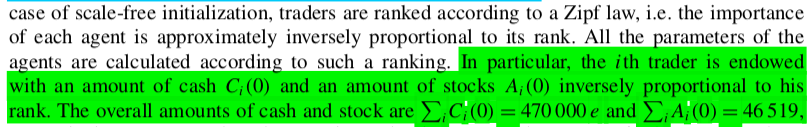

#### 初始现金和股票

In [51]:
def init_C():
    temp = 0
    for i in range(1,N+1):
        temp += 1/float(i)
    prop = allcash / temp
    C = []
    for i in range(1,N+1):
        C.append(prop*(1/i))
    return C

In [52]:
def init_A():
    temp = 0
    for i in range(1,N+1):
        temp += 1/float(i)
    prop = alla / temp
    A = []
    for i in range(1,N+1):
        A.append(prop*(1/i))
    return A

#### 网络结构和权重

In [53]:
temp = 0
for i in range(1,N+1):
    temp += 1/float(i)
prop = alle / temp
Araw = []
for i in range(1,N+1):
    Araw.append(prop*(1/i)/N)
# prob adj
padj = np.zeros((N,N))
for i in range(N):
    padj[:,i] = Araw
adj = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if random.random() < padj[i,j]:
            adj[i,j] = 1
        else:
            adj[i,j] = 0

生成的网络
- 出度是幂律
- 入度是uniform

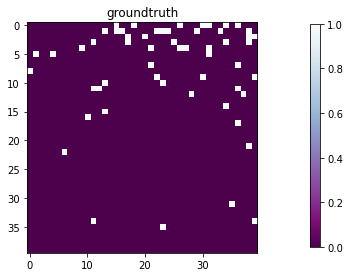

In [54]:
plt.imshow(adj, cmap=plt.cm.BuPu_r)
plt.title('groundtruth')
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# 向右，向上，宽度，高度，会互相影响
cax = plt.axes([0.85, 0.12, 0.025, 0.775])
plt.colorbar(cax=cax)

plt.show()

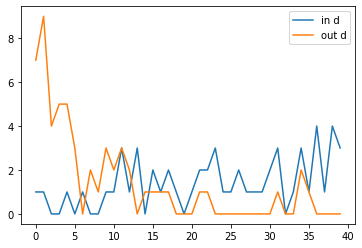

In [55]:
plt.plot(np.sum(adj,axis=0),label='in d')
plt.plot(np.sum(adj,axis=1),label='out d')
plt.legend()
plt.show()

In [56]:
G = nx.DiGraph(adj)

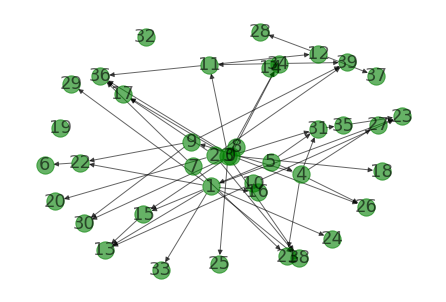

In [57]:
node_labels = G.nodes()
ld = {}#label dict
for no in G.nodes():
    ld[no] = ''+str(no)
nx.draw(G,pos=nx.spring_layout(G),labels=ld, with_labels = True,font_size=18,node_color='green',alpha=0.6)

#### 更新情绪时候的参数

In [58]:
# alpha 反比于节点序号，越往前的节点越不容易被市场影响
def init_alpha_beta_gama(maxalpha,absum,maxgama):
    alpha = []
    for i in range(1,N+1):
        alpha.append(maxalpha * (1/i))
    alpha = np.array(alpha)

    beta  = absum-alpha
    # beta = 0.1 - alpha

    # gama 正比于节点的序号，越往后的节点越容易被市场影响
    gama = np.zeros(N)
    temp = maxgama / N
    for i in range(N):
        gama[i] = (i+1)*temp
    gama = np.array(gama)

    # beta 和 gama均有0.5的可能为正或负
    beta = beta * np.sign(np.random.uniform(-1,1,N))
    gama = gama * np.sign(np.random.uniform(-1,1,N))
    return alpha,beta,gama

### 节点的情绪更新

In [59]:
def F(x):
    return max(min(x,1),-1)
#     return np.tanh(x)

# i，要更新哪个人？
# rt 昨天的回报
def update_emotion(i,rt):
    global alpha
    global beta
    global gama
    global S
    global adj
    
    # 邻居的加权平均
    ## 分母应该是连接强度的绝对值求和
    if np.sum(adj[:,i]) == 0: #如果没有邻居，就不能加权求和
        nei_s = 0
    else:
        nei_s = np.sum(adj[:,i] * S) / (np.sum(adj[:,i]))
    
    si = alpha[i] * S[i] + beta[i] * nei_s + gama[i]*rt
    si = F(si)
    return si

### 节点的投资决策，情绪>0，买

In [60]:
# i，哪个人
# pt_1，昨天的价格
# ps，需要计算波动性的最近一段的价格，每个人不一样
def trade_decision_buy(i,pt_1):
    global C
    global A
#     print('his emotion:',S[i])
    ci= S[i] * C[i] # ci花掉的现金
#     print('money he wants to spend:',ci)
    ai = ci / pt_1 # 买股票的数量
#     print('stock he wants to buy',ai)
    if ai > 10000:
        print('\n')
        print('node:',i)
        print('error')
        print('ai',ai)
        print('SI',S[i])
        print('CI',C[i])
        print('pt_1',pt_1)
        print('\n')
    return ai

### 节点投资决策，情绪<0，卖

In [61]:
# i，哪个人
# pt_1，昨天的价格
def trade_decision_sell(i):
    global S
    ai = S[i] * A[i] # 要卖的股票数量
    if ai < -10000:
        print('error')
        print('ai',ai)
        print('Si',S[i])
        print('Ai',A[i])
    return ai

### 做市商定价

In [62]:
# A：action
# logpt - logpt_1 = rt
# rt = 1/lambda*N * A
def make_price(Action,pt_1):
    a_tot = np.sum(Action)
    rt = (1/(lambda_*N)) * a_tot # return yesterday( lambda is depth of the market)
    lnp = rt + np.log(pt_1)
    p = np.exp(lnp)
    return p,rt

### 更新大家的持股数量和现金数量

In [63]:
# 更新大家的现金
def update_CA(Action,pt_1):
    global A
    global C
    # 看买入的人
    for i in range(N):
        ai = Action[i]
        # 买入
        if ai > 0:
            C[i] -= ai * pt_1
            A[i] += ai
        elif ai < 0:
            C[i] -= ai * pt_1 #(ai<0,ai*pt_1<0)
            A[i] += ai

### 市场的一天

In [103]:
# rt 昨天的收益
# pt_1 昨天的价格
# ps，所有历史价格序列
def one_day(rt,pt_1):
    global S
    # 所有人更新自己的情绪
    todayS = [0 for i in range(N)]
    for i in range(N):
        si = update_emotion(i,rt)
        todayS[i] = si
    # update global variable
    S = todayS
    ActionS = []
    
    # 所有人进行投资决策
    Action = [0 for i in range(N)] # 大家的动作
    for i in range(N):
        
        # 一个节点有0.95的概率不参与交易
        if np.random.random() > trade_prop:
            Action[i] = 0
            ActionS.append(0)
            continue
#         if i == 0:
#             print('emotion for node 0')
#             print(S[i])
#             print('----')
        # 如果他参与交易的话
        if todayS[i] > 0: # 这个人要buy
            ai= trade_decision_buy(i,pt_1)
            Action[i] = ai
            ActionS.append(S[i])
        else: # 这个人要sell
            ai = trade_decision_sell(i)
            Action[i] = ai
            ActionS.append(S[i])
#         if i ==0:
#             print('action for node 0')
#             print(ai)
#             print('---')
    return Action,ActionS

### 市场的初始化

In [65]:
seed = 2050
np.random.seed(seed)
random.seed(seed)


# 初始化
epoch_num = 1000
lambda_ = 10

# 更新情绪时候用的参数，alpha，beta，gama
maxgama = 130
maxalpha = 0.2
absum = 4 # sum of alpha and beta
alpha,beta,gama = init_alpha_beta_gama(maxalpha,absum,maxgama)

# 每天参与交易的人数比例
trade_prop = 0.4


# 所有人的初始现金
allcash = 10000
# 所有人的初始股票
alla = 16
start_price = 666.66


In [66]:
A = init_A()
C = init_C()
S = np.random.uniform(-1,1,N) # 初始情绪

### 市场的运转

In [67]:


# 记录
ps = [start_price,start_price] # prices
rts = []#收益率
AS = []#所有人的持股数量变化
CS = []#所有人的现金数量
ES = []#所有人的情绪
TradeA = []#所有人的动作（参与就是动作，没参与就是0）
TradeE = []#所有人的参与情绪（参与就是情绪，没参与就是0）

for t in range(epoch_num):

    AS.append(copy.copy(A))
    CS.append(copy.copy(C))
    ES.append(copy.copy(S))

    if t % 50 == 0:
        print('current step:',t)
    
    # 昨天的收益
    rt_1 = np.log(ps[-1]) - np.log(ps[-2]) 
#     print('rt:',rt)

    
    # 昨天的价格
    pt_1 = ps[-1] 
    
    # 开始今天的交易决策
    Action,Emotion = one_day(rt_1,pt_1)
#     print(Action)
#     d()
    TradeA.append(Action)
    TradeE.append(Emotion)
        
    # 大家进行交易，更新大家的持股数量和钱数
    update_CA(Action,pt_1)
    
    # 做市商更新今天的价格
#     print(Action)
    p,rt = make_price(Action,pt_1)


    
    # 记录今天的价格
    rts.append(rt)
    ps.append(p)
    
    # 异常值
    if rt > 100 or rt < -100:
        print(t)
        print(rt)
        print(Action)
        print(np.sum(Action))
        print(ps[-3:])
        print(rts[-3:])
        d()

current step: 0
current step: 50
current step: 100
current step: 150
current step: 200
current step: 250
current step: 300
current step: 350
current step: 400
current step: 450
current step: 500
current step: 550
current step: 600
current step: 650
current step: 700
current step: 750
current step: 800
current step: 850
current step: 900
current step: 950


In [68]:
AS = np.array(AS) #所有人的所有股票数
CS = np.array(CS) #所有人的所有现金
ES = np.array(ES) #所有人的所有情绪
TradeE = np.array(TradeE) #【step，node】所有人的交易情绪（有交易的就是情绪，没有交易的就是0）
TradeA = np.array(TradeA) #【step，node】所有人的交易动作（有交易的就是交易动作，没有交易的就是0）
# ps：价格序列
# rts,波动率序列

In [69]:
np.min(ps)

652.882500094638

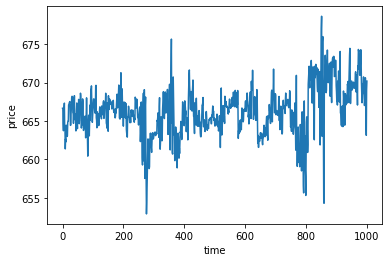

In [70]:
plt.plot(ps[:])
plt.xlabel('time')
plt.ylabel('price')
plt.show()

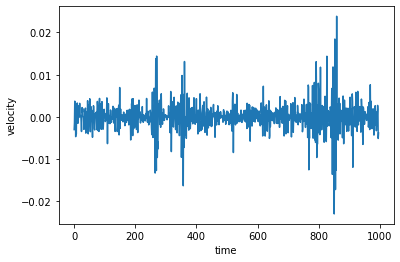

In [71]:
plt.plot(rts[:-3])
plt.xlabel('time')
plt.ylabel('velocity')
plt.show()

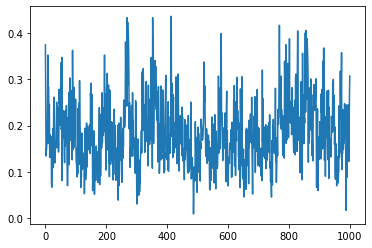

In [72]:
# 绝对值平均情绪
a = np.mean(np.abs(TradeE),axis=1)
plt.plot(a)
plt.show()

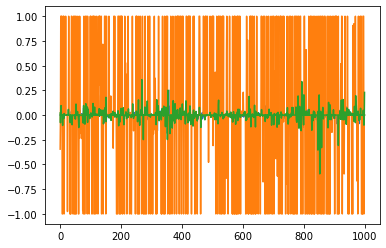

In [73]:
# 交易情绪
for i in range(5,8):
    plt.plot(TradeE[:,i])
plt.show()

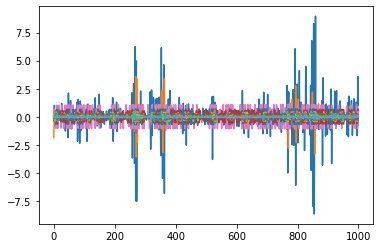

In [74]:
# 交易动作
for i in range(N):
    plt.plot(TradeA[:,i])
plt.show()

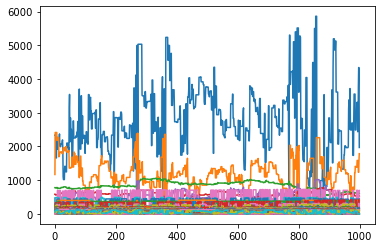

In [75]:
# 大家的现金储备
for i in range(N):
    plt.plot(CS[:,i])
plt.show()

### 存储这次价格曲线，去stat文件检查统计指标合理性

In [76]:
t = np.array(ps)

In [77]:
np.save('test.npy',t)

### 检查可学习性，即在默认规则下的loss是否低于baseline

数据的loss

In [81]:
rts = np.array(rts)
print('loss in data:',np.mean(np.abs(rts[1:]-rts[:-1])))

loss in data: 0.0029252903990251537


In [83]:
rts.shape

(1000,)

In [85]:
AS.shape

(1000, 40)

In [87]:
ps = np.array(ps)
ps = ps[2:]

In [90]:
ps.shape

(1000,)

In [91]:
ES.shape

(1000, 40)

In [113]:
pred_rts = []
pred_ps = []
for i in range(epoch_num-1):
    rt_1 = rts[i]
    pt_1 = ps[i]
    # 开始今天的交易决策
    S = ES[i]
    C = CS[i]
    A = AS[i]
    Action,Emotion = one_day(rt_1,pt_1)
    
    # 做市商更新今天的价格
    p,rt = make_price(Action,pt_1)

    # 记录今天的价格
    pred_rts.append(rt)
    pred_ps.append(p)

In [114]:
np.mean(np.abs(pred_rts-rts[1:]))

0.002842014469910595

#### 结论：模拟生成的数据的mse只比baseline低一点，说明上一步的所有人的情绪，钱数等信息都给你，你去按照模型的规则交易，生成的下一步数据是没有可预测性的，因为原始的规则就是不确定的。
模拟生成的数据的mse只比baseline低一点，说明上一步的所有人的情绪，钱数等信息都给你，你去按照模型的规则交易，生成的下一步数据是没有可预测性的，因为原始的规则就是不确定的。
模拟生成的数据的mse只比baseline低一点，说明上一步的所有人的情绪，钱数等信息都给你，你去按照模型的规则交易，生成的下一步数据是没有可预测性的，因为原始的规则就是不确定的。

### 批量生成数据

In [32]:
sampled_ps = []
sam_num = 100
for s in range(sam_num):
    print('generating sample ',s)
    # 每次重新初始化
    A = init_A()
    C = init_C()
    S = np.random.uniform(-1,1,N) # 初始情绪
    ps = [start_price,start_price] # prices
    # 每次重新初始化后的市场运转
    for t in range(epoch_num):
        # 昨天的收益
        rt_1 = np.log(ps[-1]) - np.log(ps[-2]) 

        # 昨天的价格
        pt_1 = ps[-1] 

        # 开始今天的交易决策
        Action,Emotion = one_day(rt_1,pt_1)

        # 大家进行交易，更新大家的持股数量和钱数
        update_CA(Action,pt_1)

        # 做市商更新今天的价格
        p,rt = make_price(Action,pt_1)

        # 记录今天的价格
        ps.append(p)

        # 异常值
        if rt > 100 or rt < -100:
            print(t)
            print(rt)
            print(Action)
            print(np.sum(Action))
            print(ps[-3:])
            print(rts[-3:])
            d()
    sampled_ps.append(ps)

generating sample  0
generating sample  1
generating sample  2
generating sample  3
generating sample  4
generating sample  5
generating sample  6
generating sample  7
generating sample  8
generating sample  9
generating sample  10
generating sample  11
generating sample  12
generating sample  13
generating sample  14
generating sample  15
generating sample  16
generating sample  17
generating sample  18
generating sample  19
generating sample  20
generating sample  21
generating sample  22
generating sample  23
generating sample  24
generating sample  25
generating sample  26
generating sample  27
generating sample  28
generating sample  29
generating sample  30
generating sample  31
generating sample  32
generating sample  33
generating sample  34
generating sample  35
generating sample  36
generating sample  37
generating sample  38
generating sample  39
generating sample  40
generating sample  41
generating sample  42
generating sample  43
generating sample  44
generating sample  4

In [33]:
sam_ps = np.array(sampled_ps)

In [34]:
sam_ps.shape

(100, 4002)

#### 拿出几个sample来看看

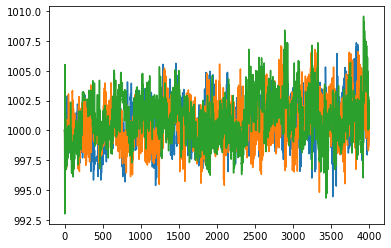

In [35]:
plt.plot(sam_ps[0])
plt.plot(sam_ps[90])
plt.plot(sam_ps[87])
plt.show()

In [36]:
np.save('generated_p0.npy',sam_ps)